# IA - Labyrinthe
## Auteur:
- Bastien Wermeille

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import random
from enum import Enum

from datetime import datetime
random.seed(datetime.now())

### Choix des hyper-paramètres

La fonction des fitnesse a été créée afin de distinguer facilement un chemin ayant atteint la but final.
En ce qui concerne le crossover, j'ai choisi la fonction shuffle car celle-ci va garder la direction final et ainsi ne pas faire régresser mon algorithme.

Les probabilités de mutations ont peu d'influence sur le résultat final de mon algorithme et les valeurs définitives ont étées choisi via essais 

In [2]:
WALL_RATIO = 0.3
MAX_TIME_S = 20
LOG = True
POPULATION_LENGTH = 150
CXPB = 0.7
MUTPB = 0.1
INDPB = 0.5

## General tools

In [3]:
def generate_labyrinth(width, height, wall_ratio=WALL_RATIO):
    '''
    Generate a random labyrinth
    
    @param width
    @param height
    @param wall_ratio
    @return (grid, start_cell, end_cell)
    '''
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [4]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    '''
    Generate a random labyrinth
    
    @param grid of the maze
    @param start_cell
    @param end_cell
    @param solution allow to display the solution
    '''
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [5]:
def load_grid(grid_file):
    '''
    Load a labyrinth from a file
    
    @param grid_file
    @return (grid, (height, width))
    '''
    grid = np.load(grid_file)
    h = grid.shape[0]
    w = grid.shape[1]
    return (grid, (h, w))

In [6]:
# grid, START_LOCATION, END_LOCATION = generate_labyrinth(WIDTH, HEIGHT, WALL_RATIO)
grid, size = load_grid("grids/grid40.npy")
WIDTH = size[0]
HEIGHT = size[1]
START_LOCATION = (0,0)
END_LOCATION = (size[0]-1,size[1]-1)
if WIDTH == 10:
    CHROMOSOME_LENGTH = 25
elif WIDTH == 15:
    CHROMOSOME_LENGTH = 32
elif WIDTH == 20:
    CHROMOSOME_LENGTH = 45
elif WIDTH == 40:
    CHROMOSOME_LENGTH = 155
else:
    CHROMOSOME_LENGTH = int((WIDTH+HEIGHT)+(1-WALL_RATIO)*WIDTH+(1-WALL_RATIO)*HEIGHT)

No solution has been found
Width :  40  Height :  40
Chromosone Length :  155


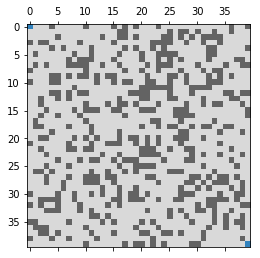

In [7]:
display_labyrinth(grid, START_LOCATION, END_LOCATION)
print("Width : ", WIDTH, " Height : ", HEIGHT)
print("Chromosone Length : ", CHROMOSOME_LENGTH)

# Data Structure

In [8]:
DIRECTIONS = {
    0: (-1, 0), # TOP
    1: (0, 1),  # RIGHT
    2: (1, 0),  # BOTTOM
    3: (0, -1), # LEFT
}
DIRECTIONS_LENGTH = len(DIRECTIONS)

## Genetic tools

In [9]:
def check_duplication_point(location, direction, previous_locations):
    '''
    Check if a given location as already been visited and if this location is crossable
    
    @param location
    @param direction given direction to check from this given location
    @param previous_locations list of the previous locations
    @return boolean disponibility of the location
    '''
    location_new = tuple(np.add(location, DIRECTIONS[direction]))
    return grid[location_new] != 1.0 and location_new not in previous_locations

In [10]:
def available_direction(location, previous_locations, start_location, targeted_location):
    '''
    Return a list of the available move at a given location regarding the previous visited locations
    
    @param location
    @param direction given direction to check from this given location
    @param previous_locations list of the previous locations
    @return list of available moves
    '''
    directions = []
    res = tuple(np.subtract(targeted_location, start_location))
    
    if location[0] > 0:
        if check_duplication_point(location, 0, previous_locations):
            directions.append(0)
            if res[0]<0:
                directions.append(0)
                directions.append(0)
    if location[0] < HEIGHT-1:
        if check_duplication_point(location, 2, previous_locations):
            directions.append(2)
            if res[0]>0:
                directions.append(2)
                directions.append(2)
    if location[1] > 0:
        if check_duplication_point(location, 3, previous_locations):
            directions.append(3)
            if res[1]<0:
                directions.append(3)
                directions.append(3)
    if location[1] < WIDTH-1:
        if check_duplication_point(location, 1, previous_locations):
            directions.append(1)
            if res[1]>0:
                directions.append(1)
                directions.append(1)
    
    return directions

In [11]:
def available_direction_simple(location):
    '''
    Return a list of the avilable move at a given location without regarding the previous visited locations
    
    @param location
    @return list of available moves
    '''
    directions = []
    
    if location[0] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[0]))
        if grid[location_new] != 1.0:
            directions.append(0)
    if location[0] < HEIGHT-1:
        location_new = tuple(np.add(location, DIRECTIONS[2]))
        if grid[location_new] != 1.0:
            directions.append(2)
    if location[1] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[3]))
        if grid[location_new] != 1.0:
            directions.append(3)
    if location[1] < WIDTH-1:
        location_new = tuple(np.add(location, DIRECTIONS[1]))
        if grid[location_new] != 1.0:
            directions.append(1)
    
    return directions

In [12]:
def validate_individual(individual, start_location, targeted_location):
    '''
    Make an individual valid as et doesn't cross any wall
    
    @param individual
    @param start_location
    @param targeted_location
    @return validated invdividual
    '''
    previous_locations = set([start_location])
    location = start_location
    direction = None
    end = False
    
    for index, direction in enumerate(individual):
        if end:
            continue
        
        # Validate every direction in an individual
        directions = available_direction(location, previous_locations, start_location, targeted_location)
        if len(directions) == 0:
            direction = random.choice(available_direction_simple(location))
        elif direction not in directions:
            # Find another valid direction
            direction = random.choice(directions)
        
        # Compute new location
        location = tuple(np.add(location, DIRECTIONS[direction]))
        
        individual[index] = direction
        previous_locations.add(location)
        
        if location == targeted_location:
            end = True
    
    return individual#, previous_locations

In [13]:
def compute_direction_to_path(individual, start_location):
    '''
    Compute the list of directions and return the list of the locations visited in order
    
    @param individual
    @param start_location
    @return computed path
    '''
    locations = [start_location]
    location = start_location
    for direction in individual:
        location = tuple(np.add(location, DIRECTIONS[direction]))
        locations.append(location)
    return locations

In [14]:
def optimise_individual(individual, locations):
    '''
    Optimise an individual to remove useless moves using only the individual information and its computed path
    
    @param individual
    @param locations computed path of the individual
    @return optimised individual
    '''
    
    i = 0
    # remove detour passing by same location
    while i < len(individual):
        if locations[i] in locations[i+1:]:
            index = locations[i+1:].index(locations[i])+i+1
            individual[:] = individual[:i]+individual[index:]
            locations[:] = locations[:i]+locations[index:]
        i += 1
    
    i=0
    while i < len(individual)-2:
        if individual[i] == (individual[i+2]+2)%4 and individual[i+1]%2 != individual[i]%2:
            individual[i] = individual[i+1]
            individual[:] = individual[:i+1]+individual[i+3:]
        i += 1
    
    return individual

In [15]:
def evaluate(individual, start_location, targeted_location):
    '''
    Evaluate an individual and return it's score but first make it valid and optimise it
    
    @param individual
    @param start_location
    @param targeted_location
    '''
    individual = validate_individual(individual, start_location, targeted_location)
    
    locations = compute_direction_to_path(individual, start_location)
    
    if targeted_location in locations:
        individual[:] = individual[:locations.index(targeted_location)]
        locations[:] = locations[:locations.index(targeted_location)+1]
        
        individual[:] = optimise_individual(individual, locations)
        
        # Score equals to the length of the path
        score = len(individual)
    else:
        # Score equals to length of the individual + the remaining distance
        distance = tuple(np.subtract(locations[-1], targeted_location))
        manhattan_distance = abs(distance[0])+abs(distance[1])
        score = len(individual) + manhattan_distance
        score *= score
    return score,

## Deap Framework

In [16]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import operator
from enum import Enum
from collections import namedtuple
import random
import time

In [17]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [18]:
toolbox.register("direction", random.randint, 0, DIRECTIONS_LENGTH-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.direction, CHROMOSOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selRoulette)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=INDPB)
toolbox.register("evaluate", evaluate, start_location=START_LOCATION, targeted_location=END_LOCATION)

## Application interface

In [19]:
def solve_labyrinth_cycle(grid, start_location, end_location, nb_cycles):
    '''
    Run the solving algorithmes with a given number of cycles
    
    @param grid
    @param start_location
    @param targeted_location
    @param nb_cycles
    @return final population
    '''
    population = toolbox.population(POPULATION_LENGTH)
    halloffame = tools.HallOfFame(1)
    
    print("\t\t Start Computing")
    print("----------------------------")
    print("Population length : ", CHROMOSOME_LENGTH)
    print("Nb cacles : ", nb_cycles)
    print("Population length : ", POPULATION_LENGTH)
    print("CXPB : ", CXPB)
    print("MUTPB : ", MUTPB)
    print("----------------------------")
    
    res = algorithms.eaSimple(population, toolbox,CXPB, MUTPB, nb_cycles, halloffame=halloffame, verbose=False)
    
    print("Best result:")
    print("\t Length : ", len(halloffame[0]) )
    
    solution = compute_direction_to_path(halloffame[0], start_location)
    display_labyrinth(grid, start_location, end_location, solution)
    
    return res

In [20]:
def solve_labyrinth(grid, start_location, end_location, max_time_s):
    '''
    Run the solving algorithmes with a given number of time
    
    @param grid
    @param start_location
    @param targeted_location
    @param nb_cycles
    @return final population
    '''
    population = toolbox.population(POPULATION_LENGTH)
    halloffame = tools.HallOfFame(1)
    
    print("\t\t Start Computing")
    print("----------------------------")
    print("Population length : ", CHROMOSOME_LENGTH)
    print("Time available : %s secondes" % max_time_s)
    print("Population length : ", POPULATION_LENGTH)
    print("CXPB : ", CXPB)
    print("MUTPB : ", MUTPB)
    print("----------------------------")
    
    start_time = inter_time = time.time()
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)
    
    nb_gen = 0
    
    # Begin the generational process
    while inter_time - start_time < max_time_s:
        nb_gen += 1
        
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Measue time
        inter_time = time.time()
        
        # Log
        if LOG: # Debug interface influence par le travail de Damian Petroff
            solution = compute_direction_to_path(halloffame[0], start_location)
            complete = end_location in solution
            print("[%s] | Time %.2f s | Length %s | Complete %s" % (nb_gen, round(inter_time - start_time, 2), len(halloffame[0]), complete))
        
    res = population

    
    print("----------------------------")
    print("Nb Generations : ", nb_gen)
    print("Best result:")
    print("\t Length : ", len(halloffame[0]) )
    
    solution = compute_direction_to_path(halloffame[0], start_location)
    display_labyrinth(grid, start_location, end_location, solution)
    
    return res

		 Start Computing
----------------------------
Population length :  155
Nb cacles :  10
Population length :  150
CXPB :  0.7
MUTPB :  0.1
----------------------------
Best result:
	 Length :  94


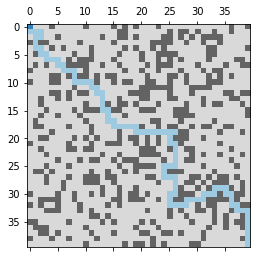

In [26]:
res = solve_labyrinth_cycle(grid, START_LOCATION, END_LOCATION, 10)

		 Start Computing
----------------------------
Population length :  155
Time available : 20 secondes
Population length :  150
CXPB :  0.7
MUTPB :  0.1
----------------------------
[1] | Time 1.63 s | Length 155 | Complete False
[2] | Time 2.33 s | Length 108 | Complete True
[3] | Time 2.97 s | Length 108 | Complete True
[4] | Time 3.66 s | Length 104 | Complete True
[5] | Time 4.29 s | Length 104 | Complete True
[6] | Time 4.94 s | Length 104 | Complete True
[7] | Time 5.62 s | Length 104 | Complete True
[8] | Time 6.27 s | Length 104 | Complete True
[9] | Time 6.86 s | Length 104 | Complete True
[10] | Time 7.50 s | Length 104 | Complete True
[11] | Time 8.27 s | Length 104 | Complete True
[12] | Time 9.07 s | Length 104 | Complete True
[13] | Time 9.74 s | Length 104 | Complete True
[14] | Time 10.44 s | Length 104 | Complete True
[15] | Time 11.00 s | Length 104 | Complete True
[16] | Time 11.73 s | Length 104 | Complete True
[17] | Time 12.44 s | Length 104 | Complete True
[18] | 

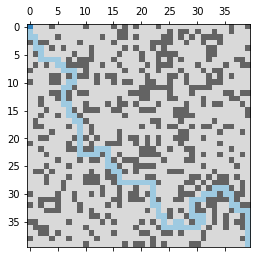

In [25]:
res = solve_labyrinth(grid, START_LOCATION, END_LOCATION, MAX_TIME_S)